In [143]:
from __future__ import annotations

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

import biotite.structure as struc
import biotite.database.rcsb as rcsb
import biotite.structure.io.pdbx as pdbx


# =========================
# Config
# =========================
RADIUS = 1.2
MARGIN = 5.0

# If you want a slightly nicer 2D view, we can scan "roll" angles around the
# first principal axis to reduce overlaps (still CA-only).
USE_BEST_ROLL = True
ROLL_STEPS = 240

# Optional gentle repel to reduce overlaps (CA-only)
USE_RELAX = True
RELAX_MIN_DIST = 0.06
RELAX_ITERS = 600

SCALE = 60.0  # just for nicer spacing

# =========================
# Residue -> letter, class -> color
# =========================
one_letter_code = {
    'ARG': 'R', 'HIS': 'H', 'LYS': 'K', 'ASP': 'D', 'GLU': 'E',
    'SER': 'S', 'THR': 'T', 'ASN': 'N', 'GLN': 'Q', 'CYS': 'C',
    'GLY': 'G', 'PRO': 'P', 'ALA': 'A', 'VAL': 'V', 'ILE': 'I',
    'LEU': 'L', 'MET': 'M', 'PHE': 'F', 'TYR': 'Y', 'TRP': 'W'
}

residue_class = {
    'ARG': 'b', 'HIS': 'b', 'LYS': 'b', 'ASP': 'a', 'GLU': 'a',
    'SER': 'w', 'THR': 'w', 'ASN': 'w', 'GLN': 'w', 'CYS': 's',
    'GLY': 'g', 'PRO': 'p', 'ALA': 'n', 'VAL': 'n', 'ILE': 'n',
    'LEU': 'n', 'MET': 's', 'PHE': 'n', 'TYR': 'n', 'TRP': 'n'
}

CLASS_TO_FILL = {
    "a": "red", "b": "skyblue", "w": "green", "g": "pink",
    "n": "white", "s": "yellow", "p": "purple",
}

def aa1(res3: str) -> str:
    return one_letter_code.get(res3.upper(), "X")

def aa_class(res3: str) -> str:
    return residue_class.get(res3.upper(), "n")


In [144]:
# =========================
# Load CA only
# =========================
def load_chain_ca(file: str, chain_id: str, model: int = 1):
    if file.endswith(".cif"):
        arr = pdbx.CIFFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif file.endswith(".pdb"):
        arr = pdbx.PDBFile.read(file)
        arr = pdbx.get_structure(arr, model=model)
    elif len(file) == 4 and file.isalnum():
        pdb_id = file
        pdb_id = pdb_id.upper()
        cif_path = rcsb.fetch(pdb_id, "cif")
        cif = pdbx.CIFFile.read(cif_path)
        arr = pdbx.get_structure(cif, model=model)
    else:
        raise ValueError(f"Unsupported file format: {file}")
    
    aa = arr[struc.filter_amino_acids(arr) & (arr.chain_id == chain_id)]
    ca = aa[aa.atom_name == "CA"]

    # sort by res_id (simple; ignores insertion codes)
    order = np.argsort(ca.res_id.astype(int))
    ca = ca[order]

    res_ids = ca.res_id.astype(int)
    res_names = ca.res_name.astype(str)
    coords3d = ca.coord.astype(float)

    print(f"Loaded {file} chain {chain_id}: {len(res_ids)} residues")
    print(f"Range: {res_ids[0]}-{res_ids[-1]} ({res_names[0]} ... {res_names[-1]})")
    return res_ids, res_names, coords3d


In [145]:
# =========================
# 3D -> 2D projection (CA-only)
# =========================
def pca_axes(X: np.ndarray):
    Xc = X - X.mean(axis=0, keepdims=True)
    _, _, Vt = np.linalg.svd(Xc, full_matrices=False)
    return Vt[0], Vt[1], Vt[2]

def rotate_about_axis(v: np.ndarray, axis: np.ndarray, theta: float) -> np.ndarray:
    axis = axis / (np.linalg.norm(axis) + 1e-12)
    v_par = np.dot(v, axis) * axis
    v_perp = v - v_par
    return v_par + v_perp*np.cos(theta) + np.cross(axis, v_perp)*np.sin(theta)

def project_best_roll(coords3d: np.ndarray, n_steps: int = 180, bead_radius: float = 1.2, seed: int = 0):
    """
    Project to 2D by PCA, but scan roll around first PC to reduce overlaps.
    Returns:
      xy_best (N,2), theta_best, score_best
    """
    rng = np.random.default_rng(seed)
    X = coords3d - coords3d.mean(axis=0, keepdims=True)

    a, b0, _ = pca_axes(X)
    a = a / (np.linalg.norm(a) + 1e-12)
    b0 = b0 / (np.linalg.norm(b0) + 1e-12)

    best = (-np.inf, None, None)

    def score_xy(xy):
        n = len(xy)
        if n < 2:
            return 0.0
        m = min(8000, n*(n-1)//2)
        i = rng.integers(0, n, size=m)
        j = rng.integers(0, n, size=m)
        mask = i != j
        d = xy[i[mask]] - xy[j[mask]]
        dist = np.sqrt((d*d).sum(axis=1))

        overlap = np.mean(dist < (2.2 * bead_radius))  # too-close fraction
        spread = float(np.quantile(dist, 0.10))        # low-quantile separation
        return -5.0*overlap + 1.0*spread

    for k in range(n_steps):
        theta = 2*np.pi*(k/n_steps)

        b = rotate_about_axis(b0, a, theta)
        b = b - np.dot(b, a) * a
        b = b / (np.linalg.norm(b) + 1e-12)

        x = X @ a
        y = X @ b
        xy = np.stack([x, y], axis=1)

        sc = score_xy(xy)
        if sc > best[0]:
            best = (sc, xy, theta)

    score_best, xy_best, theta_best = best
    xy_best = xy_best - xy_best.mean(axis=0, keepdims=True)
    span = max(np.ptp(xy_best[:, 0]), np.ptp(xy_best[:, 1]), 1e-9)
    xy_best = xy_best / span
    return xy_best, theta_best, score_best

def pca_project(coords3d: np.ndarray):
    X = coords3d - coords3d.mean(axis=0, keepdims=True)
    _, _, Vt = np.linalg.svd(X, full_matrices=False)
    xy = X @ Vt[:2].T
    xy = xy - xy.mean(axis=0, keepdims=True)
    span = max(np.ptp(xy[:, 0]), np.ptp(xy[:, 1]), 1e-9)
    return xy / span

def relax_2d(xy, target, min_dist=0.06, iters=600, repel=0.35, tether=0.15):
    """
    Gentle 2D polishing: repels close points but stays near target.
    """
    x = xy.copy()
    n = len(x)
    if n < 2:
        return x
    min_d2 = min_dist * min_dist
    for _ in range(iters):
        disp = np.zeros_like(x)
        for i in range(n):
            d = x[i] - x
            d2 = (d*d).sum(axis=1)
            mask = (d2 < min_d2) & (d2 > 1e-12)
            if not np.any(mask):
                continue
            overlap = (min_dist - np.sqrt(d2[mask]))
            vn = d[mask] / (np.sqrt(d2[mask])[:, None] + 1e-12)
            disp[i] += np.sum(vn * overlap[:, None], axis=0)
        x += repel * disp / max(n, 1)
        x += tether * (target - x)
    return x

In [146]:
def plot_front_back_subplots(xy_front,
                              xy_back,
                              res_ids,
                              res_names,
                              radius=RADIUS,
                              mask_ranges=None,
                              mask_color="lightgrey",
                              mask_alpha=0.3,
                              title_left="Front",
                              title_right="Back"):

    xy_front = np.asarray(xy_front, float)
    xy_back = np.asarray(xy_back, float)
    res_ids = np.asarray(res_ids)
    res_names = np.asarray(res_names)

    # Build mask
    if mask_ranges is not None:
        mask = np.zeros(len(res_ids), dtype=bool)
        for start, end in mask_ranges:
            mask |= (res_ids >= start) & (res_ids <= end)
    else:
        mask = np.zeros(len(res_ids), dtype=bool)

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    ax_front, ax_back = axes

    # Shared limits
    all_xy = np.vstack([xy_front, xy_back])
    minx, miny = all_xy.min(axis=0) - (MARGIN + 2*radius)
    maxx, maxy = all_xy.max(axis=0) + (MARGIN + 2*radius)

    for ax, xy, title in zip(
        [ax_front, ax_back],
        [xy_front, xy_back],
        [title_left, title_right]
    ):
        ax.set_aspect("equal")
        ax.set_title(title)

        for i, ((x, y), rn, is_masked) in enumerate(zip(xy, res_names, mask)):

            if is_masked:
                face = mask_color
                alpha = mask_alpha
            else:
                cls = aa_class(rn)
                face = CLASS_TO_FILL.get(cls, "white")
                alpha = 1.0

            z_circle = 2 * i
            z_text = z_circle + 1

            # Draw circle
            ax.add_patch(
                Circle(
                    (x, y),
                    radius=radius,
                    facecolor=face,
                    edgecolor="black",
                    linewidth=0.8,
                    alpha=alpha,
                    zorder=z_circle
                )
            )

            # Only draw text if NOT masked
            if not is_masked:
                ax.text(
                    x, y,
                    aa1(rn),
                    ha="center",
                    va="center",
                    fontsize=8,
                    zorder=z_text
                )

        # N / C always visible
        xN, yN = xy[0]
        xC, yC = xy[-1]
        top = 2 * len(xy) + 10

        ax.annotate("N", xy=(xN, yN), xytext=(xN, yN + 4*radius),
                    ha="center", arrowprops=dict(arrowstyle="-|>", lw=1),
                    zorder=top)

        ax.annotate("C", xy=(xC, yC), xytext=(xC, yC + 4*radius),
                    ha="center", arrowprops=dict(arrowstyle="-|>", lw=1),
                    zorder=top)

        ax.set_xlim(minx, maxx)
        ax.set_ylim(miny, maxy)
        ax.axis("off")

    plt.tight_layout()
    plt.show()
    return fig, axes


Loaded 4W4O chain A: 215 residues
Range: 232-446 (PRO ... GLY)
best roll theta: 0.15707963267948966 score: 8.226753258563722


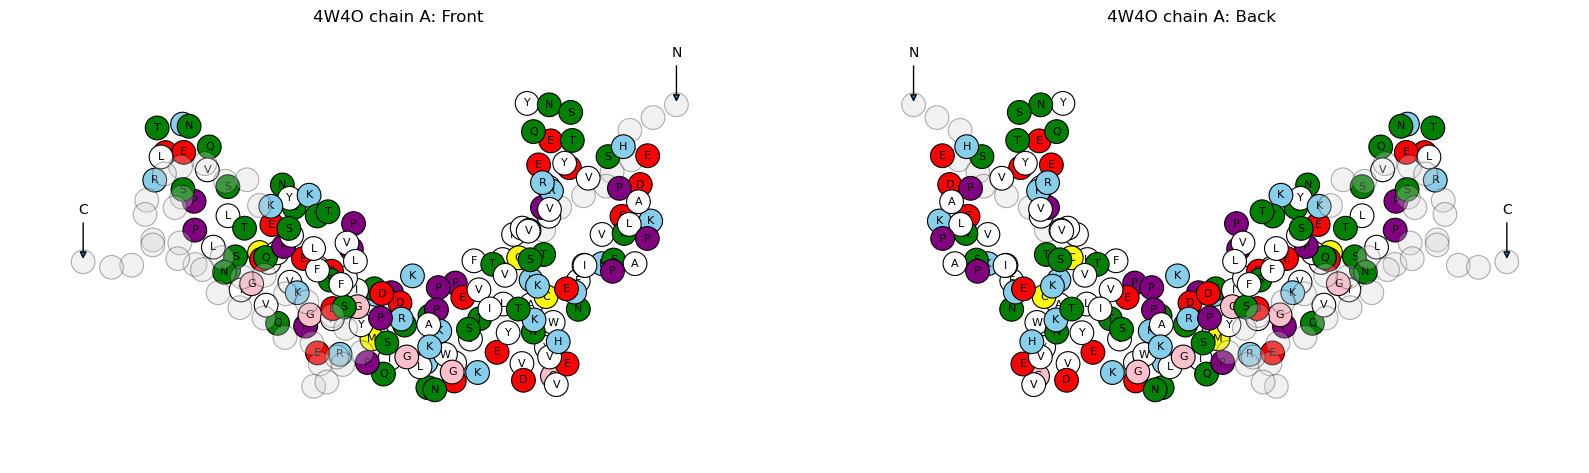

(<Figure size 1600x800 with 2 Axes>,
 array([<Axes: title={'center': '4W4O chain A: Front'}>,
        <Axes: title={'center': '4W4O chain A: Back'}>], dtype=object))

In [147]:
# =========================
# Main
# =========================
pdb = "4W4O" # can also be a local .pdb/.cif file or a 4-letter PDB ID (case-insensitive)
chain_id = "A"
model = 1
MASK_RANGES = [(232, 240), (410, 446)]
MASK_COLOR = "lightgrey"

res_ids, res_names, coords3d = load_chain_ca(pdb, chain_id, model=model)

# 1) front projection
if USE_BEST_ROLL:
    xy0, theta, sc = project_best_roll(coords3d, n_steps=ROLL_STEPS, bead_radius=RADIUS)
    print("best roll theta:", theta, "score:", sc)
else:
    xy0 = pca_project(coords3d)

xy_front = relax_2d(xy0, xy0, min_dist=RELAX_MIN_DIST, iters=RELAX_ITERS) if USE_RELAX else xy0

# 2) back view: flip x-axis (180° around "up" axis in camera frame)
xy_back = xy_front.copy()
xy_back[:, 0] *= -1.0

# 3) scale for plotting
xy_front_plot = xy_front * SCALE
xy_back_plot = xy_back * SCALE

# 4) plot two images
plot_front_back_subplots(
    xy_front_plot,
    xy_back_plot,
    res_ids,
    res_names,
    radius=RADIUS,
    mask_ranges=MASK_RANGES,
    mask_color=MASK_COLOR,
    title_left=f"{pdb} chain {chain_id}: Front",
    title_right=f"{pdb} chain {chain_id}: Back"
)
